# Capture Wikipedia polling data and produce LOWESS charts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Check-raw-data-tallies-to-100%" data-toc-modified-id="Check-raw-data-tallies-to-100%-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check raw data tallies to 100%</a></span><ul class="toc-item"><li><span><a href="#Report-problematic-voting-intention-data" data-toc-modified-id="Report-problematic-voting-intention-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Report problematic voting intention data</a></span></li><li><span><a href="#Report-problematic-attitudinal-data" data-toc-modified-id="Report-problematic-attitudinal-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Report problematic attitudinal data</a></span></li></ul></li><li><span><a href="#Attribute-undecideds-(force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-undecideds-(force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute undecideds (force polls to sum to 100 percent)</a></span></li><li><span><a href="#Calculate-2pp-based-on-preference-flows-at-the-2019-election" data-toc-modified-id="Calculate-2pp-based-on-preference-flows-at-the-2019-election-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate 2pp based on preference flows at the 2019 election</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#Plotting-constants" data-toc-modified-id="Plotting-constants-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plotting constants</a></span></li><li><span><a href="#Plots-with-summary-lines-by-individual-pollsters" data-toc-modified-id="Plots-with-summary-lines-by-individual-pollsters-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plots with summary lines by individual pollsters</a></span></li><li><span><a href="#All-poll-aggregations" data-toc-modified-id="All-poll-aggregations-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>All poll aggregations</a></span></li><li><span><a href="#Preferred-Prime-Minister" data-toc-modified-id="Preferred-Prime-Minister-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Preferred Prime Minister</a></span></li><li><span><a href="#Satisfaction-charts" data-toc-modified-id="Satisfaction-charts-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Satisfaction charts</a></span></li></ul></li><li><span><a href="#Check-for-under-dispersion-with-poll-results" data-toc-modified-id="Check-for-under-dispersion-with-poll-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Check for under-dispersion with poll results</a></span><ul class="toc-item"><li><span><a href="#Check-all---using-a-simple-arithmetic-mean" data-toc-modified-id="Check-all---using-a-simple-arithmetic-mean-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Check all - using a simple arithmetic mean</a></span></li><li><span><a href="#Check-all-pollsters-but-Essential---against-a-moving-average" data-toc-modified-id="Check-all-pollsters-but-Essential---against-a-moving-average-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Check all pollsters but Essential - against a moving average</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Save files</a></span></li><li><span><a href="#Check-for-any-problems-with-data-capture-and-cleaning" data-toc-modified-id="Check-for-any-problems-with-data-capture-and-cleaning-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Check for any problems with data capture and cleaning</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

# web
import requests

# standard python imports
import platform, sys, os, pathlib
from io import StringIO
from typing import List
import time

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN
from common import P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_OTHER, P_COLOR_GREEN

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon May 09 2022 13:07:05

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

platform   : 1.0.8
pandas     : 1.4.2
scipy      : 1.8.0
matplotlib : 3.5.2
statsmodels: 0.13.2
requests   : 2.27.1
numpy      : 1.22.3
sys        : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:42:03) [Clang 12.0.1 ]

Watermark: 2.3.0



In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = 'Polling data from Wikipedia. '

In [4]:
# saving downloaded files
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

## Get Wikipedia polling data

In [5]:
def get_url_tables(url: str) -> str:
    headers = {
        'Cache-Control': 'no-cache, must-revalidate, private, max-age=0',
        'Pragma': 'no-cache',
    }
    r = requests.get(url.format(rn=time.time()), headers=headers)
    #print(r.headers)
    assert(r.status_code == 200) # successful retrieval
    text = r.text
    return pd.read_html(text)
    
WIKIURL = 'https://en.wikipedia.org/wiki/Opinion_polling_for_the_2022_Australian_federal_election'
table_list = get_url_tables(WIKIURL)

In [6]:
def extract_polling_tables(table_list):
    sought = {
        # description:              table numbers in table_list
        "Voting intention":         [1, 2],
        "Preferred prime minister": [3],
    }

    table_dict = {}
    for item, table_numbers in sought.items():
        captured = []
        returnable = None
        for table_number in table_numbers:
            table = table_list[table_number]
            returnable = table if returnable is None else pd.concat([returnable, table])
        table_dict[item] = returnable
    return table_dict

table_dict = extract_polling_tables(table_list)

In [7]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(f'{key} (length={len(table)})')
    display(table.iloc[:15])
    print('=' * 40)

Voting intention (length=159)


Date                                           Brand  \
                   Date                                           Brand   
0            8 May 2022  Second election leaders debate at Nine Network   
1          4–7 May 2022                              Newspoll-YouGov[6]   
2          4–7 May 2022                                        Ipsos[7]   
3   25 April–1 May 2022                                   Roy Morgan[8]   
4      27–30 April 2022                                    Essential[9]   
5      27–30 April 2022                             Newspoll-YouGov[10]   
6      27–30 April 2022                           Resolve Strategic[11]   
7      18–24 April 2022                                  Roy Morgan[12]   
8      20–23 April 2022                             Newspoll-YouGov[13]   
9      20–23 April 2022                                       Ipsos[14]   
10        20 April 2022     First election leaders debate with Sky News   
11     19–20 April 2022                                   Essential[15]   
12     11–17 April 2022                                  Roy Morgan[16]   
13     14–17 April 2022                             Newspoll-YouGov[17]   
14     11–16 April 2022                           Resolve Strategic[18]   

                                    Interview mode  \
                                    Interview mode   
0   Second election leaders debate at Nine Network   
1                                           Online   
2                                 Telephone/Online   
3                                 Telephone/online   
4                                           Online   
5                                           Online   
6                                           Online   
7                                 Telephone/online   
8                                           Online   
9                                 Telephone/online   
10     First election leaders debate with Sky News   
11                                          Online   
12                                Telephone/online   
13                                          Online   
14                                          Online   

                                       Sample size  \
                                       Sample size   
0   Second election leaders debate at Nine Network   
1                                             1523   
2                                             2311   
3                                             1487   
4                                             1500   
5                                             1538   
6                                             1408   
7                                             1393   
8                                             1538   
9                                             2302   
10     First election leaders debate with Sky News   
11                                            1052   
12                                            1382   
13                                            1510   
14                                            1404   

                                      Primary vote  \
                                              L/NP   
0   Second election leaders debate at Nine Network   
1                                              35%   
2                                              29%   
3                                              35%   
4                                              36%   
5                                              36%   
6                                              33%   
7                                            35.5%   
8                                              36%   
9                                              32%   
10     First election leaders debate with Sky News   
11                                             37%   
12                                           35.5%   
13                                             35%   
14                                       

Preferred prime minister (length=81)


Date                          Brand               Firm  \
         Unnamed: 0_level_1             Unnamed: 1_level_1 Unnamed: 2_level_1   
0              4–7 May 2022                          Ipsos              Ipsos   
1          20–23 April 2022                   Newspoll[13]             YouGov   
2          20–23 April 2022                      Ipsos[14]              Ipsos   
3          17–20 April 2022                  Essential[15]          Essential   
4          11–16 April 2022  Resolve Political Monitor[18]  Resolve Strategic   
5            6–9 April 2022                   Newspoll[20]             YouGov   
6   31 March – 3 April 2022      Resolve Political Monitor  Resolve Strategic   
7   31 March – 3 April 2022                       Newspoll             YouGov   
8   31 March – 2 April 2022                          Ipsos              Ipsos   
9           9–12 March 2022                   Newspoll[30]             YouGov   
10      23–26 February 2022                   Newspoll[33]             YouGov   
11      17–20 February 2022                  Essential[36]          Essential   
12       9–12 February 2022                   Newspoll[38]             YouGov   
13       27–30 January 2022                   Newspoll[40]             YouGov   
14       20–23 January 2022                  Essential[36]          Essential   

       Interview mode        Sample size Preferred Prime Minister           \
   Unnamed: 3_level_1 Unnamed: 4_level_1                 Morrison Albanese   
0    Telephone/Online               2311                      36%      41%   
1    Telephone/Online               1538                      46%      37%   
2    Telephone/Online               2302                      38%      40%   
3              Online               1052                      40%      36%   
4              Online               1404                      38%      30%   
5              Online               1506                      44%      39%   
6              Online               1681                      36%      37%   
7              Online               1531                      43%      42%   
8    Telephone/Online               2563                      37%      38%   
9              Online               1520                      42%      42%   
10             Online               1525                      42%      40%   
11             Online               1089                      40%      35%   
12             Online               1526                      43%      38%   
13             Online               1523                      43%      41%   
14             Online               1001                      42%      35%   

               Morrison                          Albanese               \
   Don't Know Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
0         24%       32%          51%        18%       30%          36%   
1         17%       42%          54%         4%       38%          50%   
2         22%       34%          48%        18%       31%          35%   
3         24%       44%          48%         8%       41%          41%   
4         32%       44%          47%         9%       35%          44%   
5         17%       42%          54%         4%       42%          45%   
6         15%       39%          53%         8%       38%          42%   
7         15%       42%          54%         4%       43%          44%   
8         25%       33%          48%        19%       30%          32%   
9         16%       41%          55%         4%       44%          42%   
10        18%       43%          55%         2%       44%          43%   
11        25%       44%          49%         7%       43%          40%   
12        19%       40%          56%         4%       40%          46%   
13        16%       39%          58%         3%       43%          43%   
14        23%       46%          46%         8%       39%          39%   

               
   Don't Know  
0         34%  
1         1

## Data cleaning

In [8]:
cleaned = {}
for key, table in table_dict.items():
    cleaned[key] = common.clean(table)
    display(cleaned[key].tail(3))

Date            Brand    Interview mode  \
                              Date            Brand    Interview mode   
(Mean Date, )                                                           
2022-04-28     25 April–1 May 2022       Roy Morgan  Telephone/online   
2022-05-05            4–7 May 2022            Ipsos  Telephone/Online   
2022-05-05            4–7 May 2022  Newspoll-YouGov            Online   

              Sample size Primary vote                             2pp vote  \
              Sample size         L/NP   ALP   GRN  ONP  UAP   OTH      UND   
(Mean Date, )                                                                 
2022-04-28         1487.0         35.0  35.0  13.0  3.0  1.0  13.0      NaN   
2022-05-05         2311.0         29.0  35.0  12.0  4.0  3.0  10.0      7.0   
2022-05-05         1523.0         35.0  39.0  11.0  5.0  4.0   6.0      NaN   

                           
               L/NP   ALP  
(Mean Date, )              
2022-04-28     44.5  55.5  
2022-05-05     43.0  57.0  
2022-05-05     46.0  54.0

Date      Brand       Firm    Interview mode  \
                                                                          
(Mean Date, )                                                             
2022-04-18     17–20 April 2022  Essential  Essential            Online   
2022-04-21     20–23 April 2022      Ipsos      Ipsos  Telephone/Online   
2022-04-21     20–23 April 2022   Newspoll     YouGov  Telephone/Online   

              Sample size Preferred Prime Minister                      \
                                          Morrison Albanese Don't Know   
(Mean Date, )                                                            
2022-04-18         1052.0                     40.0     36.0       24.0   
2022-04-21         2302.0                     38.0     40.0       22.0   
2022-04-21         1538.0                     46.0     37.0       17.0   

               Morrison                          Albanese               \
              Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
(Mean Date, )                                                            
2022-04-18         44.0         48.0        8.0      41.0         41.0   
2022-04-21         34.0         48.0       18.0      31.0         35.0   
2022-04-21         42.0         54.0        4.0      38.0         50.0   

                          
              Don't Know  
(Mean Date, )             
2022-04-18          17.0  
2022-04-21          34.0  
2022-04-21          12.0

## Check raw data tallies to 100%

In [9]:
def check_row_sums(df: pd.DataFrame, columns: str) -> None:
    """Identify when rows do not add to 100%."""
    
    row_totals = (
        df[
            df.columns[
                df
                .columns
                .get_level_values(0) == columns
            ]
        ]
        .sum(axis=1, skipna=True)
    )
    problematic = (row_totals != 0) & ((row_totals < 99) | (row_totals > 101))

    # If any rows have any row-addition problem ... let's report them
    if problematic.any():
        common.warn(f'check_row_sums() found issues with {columns}')
        output = df.copy()
        output[(columns, 'ROW TOTALS')] = row_totals
        display(output[problematic])
        print('=' * 50)
        del output

### Report problematic voting intention data

Note: 
*  Essential and Ipsos do not attribute undecideds to 2pp. So their 2pp totals do not total to 100%
*  More problematic is the primary votes that do not total to 100%

In [10]:
vi = cleaned['Voting intention'].copy()
attitudinal = cleaned['Preferred prime minister'].copy()

check_row_sums(vi, '2pp vote')
check_row_sums(vi, 'Primary vote')


check_row_sums() found issues with 2pp vote


Date  Brand    Interview mode Sample size  \
                           Date  Brand    Interview mode Sample size   
(Mean Date, )                                                          
2022-04-21     20–23 April 2022  Ipsos  Telephone/online      2302.0   
2022-05-05         4–7 May 2022  Ipsos  Telephone/Online      2311.0   

              Primary vote                             2pp vote              \
                      L/NP   ALP   GRN  ONP  UAP   OTH      UND  L/NP   ALP   
(Mean Date, )                                                                 
2022-04-21            32.0  34.0  12.0  4.0  3.0   8.0      8.0  45.0  55.0   
2022-05-05            29.0  35.0  12.0  4.0  3.0  10.0      7.0  43.0  57.0   

                          
              ROW TOTALS  
(Mean Date, )             
2022-04-21         108.0  
2022-05-05         107.0

check_row_sums() found issues with Primary vote


Date      Brand    Interview mode  \
                                       Date      Brand    Interview mode   
(Mean Date, )                                                              
2020-01-27     20 January – 3 February 2020        ANU       CATI/online   
2020-06-08                      8 June 2020  Essential            Online   
2020-06-15                     15 June 2020  Essential            Online   
2020-06-22                     22 June 2020  Essential            Online   
2020-06-29                     29 June 2020  Essential            Online   
2020-07-13                     13 July 2020  Essential            Online   
2020-07-24                  23–26 July 2020  Essential            Online   
2020-08-10                   10 August 2020  Essential            Online   
2020-08-24                   24 August 2020  Essential            Online   
2020-09-07                 7 September 2020  Essential            Online   
2020-09-21                21 September 2020  Essential            Online   
2020-10-05                   5 October 2020  Essential            Online   
2020-10-12                  12 October 2020  Essential            Online   
2020-10-16               14–19 October 2020  Essential            Online   
2020-11-02                  2 November 2020  Essential            Online   
2020-11-16                 16 November 2020  Essential            Online   
2020-11-30                 30 November 2020  Essential            Online   
2020-12-14                 14 December 2020  Essential            Online   
2021-01-18                  18 January 2021  Essential            Online   
2021-01-29     27 January – 1 February 2021  Essential            Online   
2021-02-15                 15 February 2021  Essential            Online   
2021-03-01                     1 March 2021  Essential            Online   
2021-03-15                    15 March 2021  Essential            Online   
2021-03-29                    29 March 2021  Essential            Online   
2021-04-12                    12 April 2021  Essential            Online   
2021-04-26                    26 April 2021  Essential            Online   
2021-05-10                      10 May 2021  Essential            Online   
2021-05-24                      24 May 2021  Essential            Online   
2021-06-07                      7 June 2021  Essential            Online   
2021-06-21                     21 June 2021  Essential            Online   
2021-07-05                      5 July 2021  Essential            Online   
2021-07-19                     19 July 2021  Essential            Online   
2021-08-02                    2 August 2021  Essential            Online   
2021-08-16                   16 August 2021  Essential            Online   
2021-08-27                25–29 August 2021  Essential            Online   
2021-09-10              8–12 September 2021  Essential            Online   
2021-09-24             22–26 September 2021  Essential            Online   
2021-10-08                6–10 October 2021  Essential            Online   
2021-10-22               20–24 October 2021  Essential            Online   
2021-11-05                3–7 November 2021  Essential            Online   
2021-11-19              17–21 November 2021  Essential            Online   
2021-12-03                1–5 December 2021  Essential            Online   
2021-12-10               8–13 December 2021  Essential            Online   
2022-01-21               20–23 January 2022  Essential            Online   
2022-02-04                2–6 February 2022  Essential            Online   
2022-02-18              17–20 February 2022  Essential            Online   
2022-03-04                   2–6 March 2022  Essential            Online   
2022-03-18                 17–20 March 2022  Essential            Online   
2022-03-31          30 March – 2 April 2022      Ipsos  Telephone/online   
2022-03-31          30 March – 2 April 2022  Essential            Online   
2022-04-19 

### Report problematic attitudinal data

In [11]:
check_row_sums(attitudinal, 'Preferred Prime Minister')
check_row_sums(attitudinal, 'Morrison')
check_row_sums(attitudinal, 'Albanese')

check_row_sums() found issues with Preferred Prime Minister


Date                      Brand  \
                                                                    
(Mean Date, )                                                       
2022-04-01     31 March – 3 April 2022  Resolve Political Monitor   

                            Firm Interview mode Sample size  \
                                                              
(Mean Date, )                                                 
2022-04-01     Resolve Strategic         Online      1681.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2022-04-01                        36.0     37.0       15.0      39.0   

                                       Albanese                          \
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know   
(Mean Date, )                                                             
2022-04-01            53.0        8.0      38.0         42.0       20.0   

              Preferred Prime Minister  
                            ROW TOTALS  
(Mean Date, )                           
2022-04-01                        88.0

check_row_sums() found issues with Albanese


Date                      Brand  \
                                                               
(Mean Date, )                                                  
2020-08-06        5–8 August 2020                   Newspoll   
2022-01-13     11–15 January 2022  Resolve Political Monitor   

                            Firm Interview mode Sample size  \
                                                              
(Mean Date, )                                                 
2020-08-06                YouGov         Online      1509.0   
2022-01-13     Resolve Strategic         Online      1607.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2020-08-06                        60.0     25.0       15.0      68.0   
2022-01-13                        38.0     31.0       31.0      41.0   

                                       Albanese                          \
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know   
(Mean Date, )                                                             
2020-08-06            29.0        3.0      41.0         38.0       15.0   
2022-01-13            50.0        9.0      34.0         41.0       28.0   

                          
              ROW TOTALS  
(Mean Date, )             
2020-08-06          94.0  
2022-01-13         103.0

## Attribute undecideds (force polls to sum to 100 percent)

And remove the hierarchical index

In [12]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    if (column, 'UND') in data.columns:
        data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [13]:
vi = cleaned['Voting intention'].reset_index()

tpp = attribute('2pp vote', vi).copy()
tpp.columns = common.flatten_col_names(tpp.columns)
tpp = tpp[tpp['2pp vote L/NP'].notna()] # remove nans

pv = attribute('Primary vote', vi).copy()
pv.columns = common.flatten_col_names(pv.columns)
pv = pv[pv['Primary vote L/NP'].notna()] # remove nans

ppm = cleaned['Preferred prime minister'].reset_index().copy()
ppm.columns = common.flatten_col_names(ppm.columns)

del vi

In [14]:
# quick check, does the adjusted primary vote tally to 100%
columns = pv.columns[pv.columns.str.contains('Primary vote')]
row_sums = pv[columns].sum(axis=1)
check = (row_sums < 99.9) | (row_sums > 100.1)
if check.any():
    common.warn(f'Problematic primary vote polling data')
    pv[check]
    row_sums[check]

In [15]:
# A quick sanity check on the final tables ...
# Are the values within the typical long-run expectations
def final_sanity_check():
    checker = {
        # column: [in-DataFrame, middle-value, plus-or-minus-span]
        '2pp vote L/NP': [tpp, 50, 6],
        '2pp vote ALP': [tpp, 50, 6],
        'Primary vote L/NP': [pv, 39, 7],
        'Primary vote ALP': [pv, 39, 8],
        'Primary vote GRN': [pv, 12, 7],
        'Primary vote OTH': [pv, 12, 7],
        'Primary vote UAP': [pv, 4, 3.5],
        'Primary vote ONP': [pv, 4, 3.5],
    }

    # check for any odd rows
    for col, (df, target, threshold) in checker.items():
        odd = df[col].notna() & ((df[col] - target).abs() > threshold)
        if odd.sum():
            common.warn(f'final_sanity_check() found an issue with "{col}"')
            display(df[odd])

final_sanity_check()

final_sanity_check() found an issue with "2pp vote L/NP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November,4–5 December 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 January 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 January – 13 February 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 February 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 February – 3 March 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 March – 3 April 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
137,43.0,57.0,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0
149,43.0,57.0,4–7 May 2022,2022-05-05,Ipsos,Telephone/Online,2311.0


final_sanity_check() found an issue with "2pp vote ALP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November,4–5 December 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 January 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 January – 13 February 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 February 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 February – 3 March 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 March – 3 April 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
137,43.0,57.0,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0
149,43.0,57.0,4–7 May 2022,2022-05-05,Ipsos,Telephone/Online,2311.0


final_sanity_check() found an issue with "Primary vote L/NP"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
128,31.000000,37.500000,12.000000,3.000000,1.000000,15.500000,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
149,31.182796,37.634409,12.903226,4.301075,3.225806,10.752688,4–7 May 2022,2022-05-05,Ipsos,Telephone/Online,2311.0


final_sanity_check() found an issue with "Primary vote OTH"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
121,37.234043,40.425532,9.574468,5.319149,3.191489,4.255319,17–20 February 2022,2022-02-18,Essential,Online,1089.0
125,39.560440,38.461538,10.989011,3.296703,3.296703,4.395604,2–6 March 2022,2022-03-04,Essential,Online,1093.0
129,40.217391,40.217391,9.782609,3.260870,2.173913,4.347826,17–20 March 2022,2022-03-18,Essential,Online,1091.0


## Calculate 2pp based on preference flows at the 2019 election

In [16]:
vote_transfer = """
from,              transfer to L/NP, transfer to ALP
Primary vote L/NP, 0.999,             0.001
Primary vote ALP,  0.0,               1.0
Primary vote GRN,  0.178,             0.822
Primary vote ONP,  0.652,             0.348
Primary vote UAP,  0.651,             0.349
Primary vote OTH,  0.493,             0.507
"""
# see: https://antonygreen.com.au/preference-flows-at-the-2019-federal-election/


vt = pd.read_csv(StringIO(vote_transfer), header=0, index_col=0,
                  skipinitialspace=True)

# Check that the rows in this table all sum to 1
if not (vt.sum(axis=1) == 1.0).all():
    common.warn('Check the primary vote transfer table used for calculating 2pp')

In [17]:
CALC_TPP_LNP, CALC_TPP_ALP = 'Calculated 2pp L/NP', 'Calculated 2pp ALP'
pv[CALC_TPP_LNP] = pv[vt.index].mul(vt['transfer to L/NP'], axis=1).sum(axis=1)
pv[CALC_TPP_ALP] = pv[vt.index].mul(vt['transfer to ALP'], axis=1).sum(axis=1)

# let's look at the last few rows
pv.tail(3)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
148,35.000000,35.000000,13.000000,3.000000,1.000000,13.000000,25 April–1 May 2022,2022-04-28,Roy Morgan,Telephone/online,1487.0,46.295000,53.705000
149,31.182796,37.634409,12.903226,4.301075,3.225806,10.752688,4–7 May 2022,2022-05-05,Ipsos,Telephone/Online,2311.0,43.653763,56.346237
150,35.000000,39.000000,11.000000,5.000000,4.000000,6.000000,4–7 May 2022,2022-05-05,Newspoll-YouGov,Online,1523.0,45.745000,54.255000


In [18]:
# check calculated TPP adds to 100%
sums = pv[[CALC_TPP_LNP, CALC_TPP_ALP]].sum(axis=1)
check = (sums < 99.9) | (sums > 100.1)
if any(check):
    common.warn(f'Problematic calculation of 2pp vote share from primary vote polling')
    pv[check]
    sums[check]

In [19]:
# let's look at the more than one percentage point mismatch rows with pollster calculated 2pp
combo = pv.copy()
del combo['Calculated 2pp ALP']
combo['2pp vote L/NP'] = tpp['2pp vote L/NP']
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() >= 1.0
combo[problematic]

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
29,42.222222,37.777778,10.000000,4.444444,NaN,5.555556,10 August 2020,2020-08-10,Essential,Online,NaN,49.596667,51.111111
31,41.935484,37.634409,9.677419,4.301075,NaN,6.451613,24 August 2020,2020-08-24,Essential,Online,NaN,49.601075,51.086957
33,41.304348,34.782609,10.869565,3.260870,NaN,9.782609,7 September 2020,2020-09-07,Essential,Online,NaN,50.146739,48.913043
35,45.054945,34.065934,10.989011,4.395604,NaN,5.494505,21 September 2020,2020-09-21,Essential,Online,NaN,52.540659,53.846154
39,41.935484,37.634409,9.677419,3.225806,NaN,7.526882,14–19 October 2020,2020-10-16,Essential,Online,NaN,49.430108,51.612903
45,44.565217,35.869565,8.695652,4.347826,NaN,6.521739,30 November 2020,2020-11-30,Essential,Online,NaN,52.118478,53.260870
78,39.784946,38.709677,10.752688,4.301075,NaN,6.451613,19 July 2021,2021-07-19,Essential,Online,NaN,47.644086,48.913043
83,40.659341,39.560440,9.890110,3.296703,NaN,6.593407,16 August 2021,2021-08-16,Essential,Online,NaN,47.779121,48.913043
102,38.888889,41.111111,10.000000,3.333333,NaN,6.666667,3–7 November 2021,2021-11-05,Essential,Online,1089.0,46.090000,48.888889
104,35.500000,35.500000,12.000000,3.500000,NaN,13.500000,"13–14, 20–21 November 2021",2021-11-17,Roy Morgan,Telephone/online,2795.0,46.538000,44.500000


In [20]:
# warn if the mismatch is greater than 2.5 percentage points
THRESHOLD = 2.5
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() > THRESHOLD
if problematic.sum():
    common.warn('There is a substantial mismatch with pollster 2pp at\n\t'
         f'{combo.loc[problematic, "Mean Date"].dt.date.values}')
    display(combo[problematic])

There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
102,38.888889,41.111111,10.0,3.333333,NaN,6.666667,3–7 November 2021,2021-11-05,Essential,Online,1089.0,46.09,48.888889


In [21]:
pv.tail(15)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
136,36.000000,37.000000,10.000000,3.000000,4.000000,10.000000,6–9 April 2022,2022-04-07,Newspoll-YouGov,Online,1506.0,47.234000,52.766000
137,32.500000,36.000000,12.500000,5.000000,1.500000,12.500000,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0,45.091500,54.908500
138,34.653465,33.663366,10.891089,3.960396,3.960396,12.871287,11–16 April 2022,2022-04-13,Resolve Strategic,Online,1404.0,48.063366,51.936634
139,35.500000,35.000000,14.000000,4.500000,1.500000,9.500000,11–17 April 2022,2022-04-14,Roy Morgan,Telephone/online,1382.0,46.550500,53.449500
140,35.000000,36.000000,12.000000,4.000000,4.000000,9.000000,14–17 April 2022,2022-04-15,Newspoll-YouGov,Online,1510.0,46.750000,53.250000
141,39.784946,37.634409,9.677419,3.225806,4.301075,5.376344,19–20 April 2022,2022-04-19,Essential,Online,1052.0,49.021505,50.978495
142,34.408602,36.559140,12.903226,4.301075,3.225806,8.602151,20–23 April 2022,2022-04-21,Ipsos,Telephone/online,2302.0,45.816129,54.183871
143,36.000000,37.000000,11.000000,3.000000,4.000000,9.000000,20–23 April 2022,2022-04-21,Newspoll-YouGov,Online,1538.0,46.919000,53.081000
144,35.500000,35.000000,12.000000,4.500000,1.500000,11.500000,18–24 April 2022,2022-04-21,Roy Morgan,Telephone/online,1393.0,47.180500,52.819500
145,33.000000,34.000000,15.000000,5.000000,5.000000,8.000000,27–30 April 2022,2022-04-28,Resolve Strategic,Online,1408.0,46.096000,53.904000


## Quick plots

In [22]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')


### Plotting constants

In [23]:
# constants ...
HALF_LIFE_DAYS = 14 # days
HALF_LIFE = pd.Timedelta(days=HALF_LIFE_DAYS)
LOWESS_PERIOD = 120 # days

# For primaries vote polls ...
PARTIES = ['Coalition', 'Labor', 'Greens', 'Other']
COLUMNS = ['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
           ['Primary vote ONP', 'Primary vote OTH']]
L_COLORS = [COLOR_COALITION, COLOR_LABOR, COLOR_GREEN, COLOR_OTHER]
P_COLORS = [P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_GREEN, P_COLOR_OTHER]

# For 2pp polls ...
TPP_PARTIES = ('Coalition', 'Labor')
TPP_P_COLORS = (P_COLOR_COALITION, P_COLOR_LABOR)
TPP_L_COLORS = (COLOR_COALITION, COLOR_LABOR)

# 
FUNCTIONS = common.calculate_ewm, common.calculate_lowess,
ARGUMENTS = HALF_LIFE, LOWESS_PERIOD
LFOOTERS = (
    LFOOTER + f'; Half-life = {HALF_LIFE_DAYS} days', 
    LFOOTER + f'; LOWESS period = {LOWESS_PERIOD} days'
)
TITLE_STEMS = 'Exponentially Weighted Poll Average', 'LOWESS Regression'

### Plots with summary lines by individual pollsters

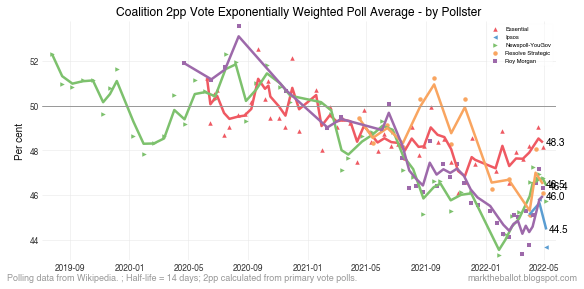

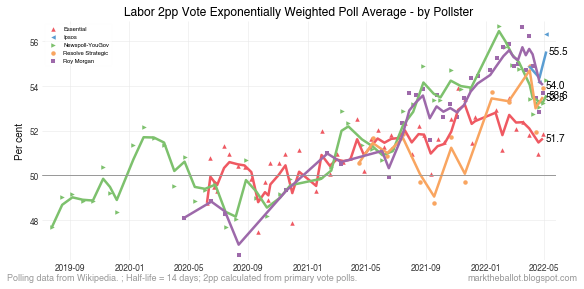

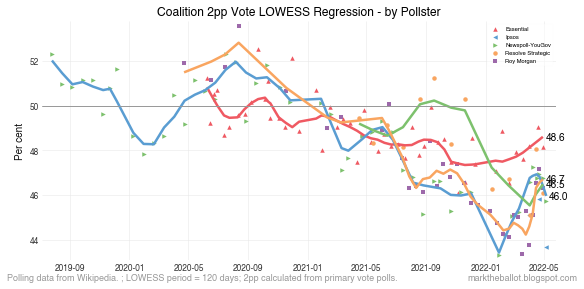

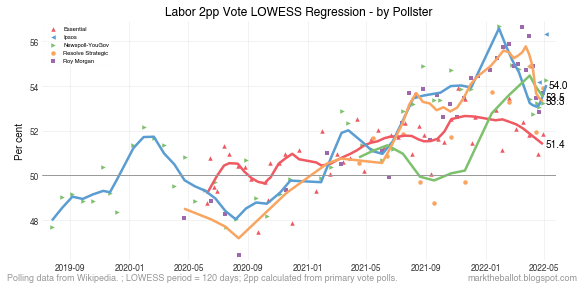

In [24]:
# 2pp ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')

llfooter = '; 2pp calculated from primary vote polls.'
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(TPP_PARTIES, TPP_COLUMNS):
        title = f'{party} 2pp Vote {stem} - by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter+llfooter)        


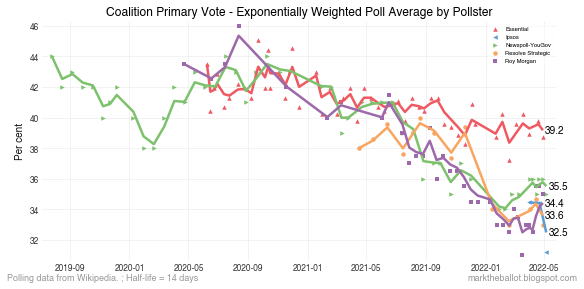

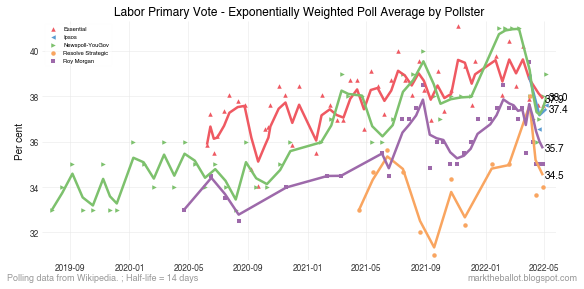

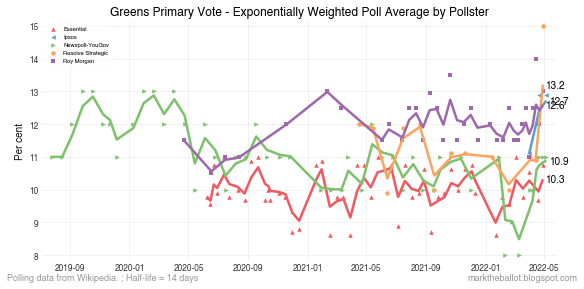

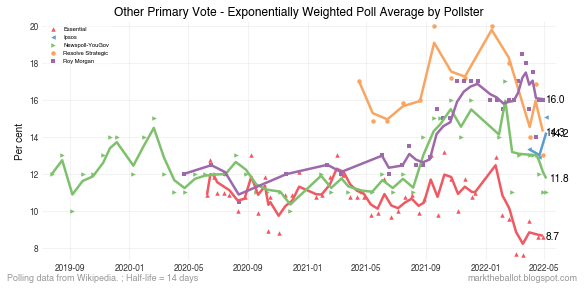

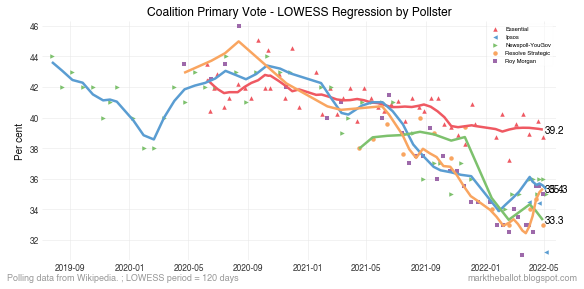

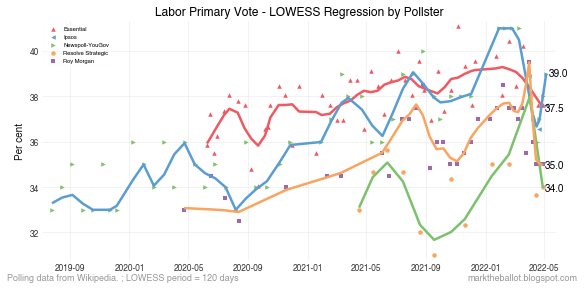

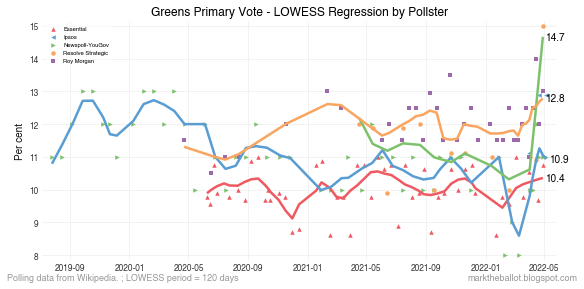

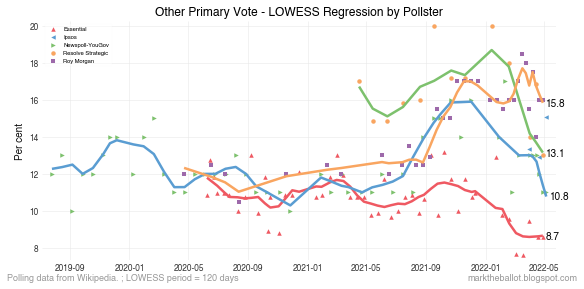

In [25]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(PARTIES, COLUMNS):
        title = f'{party} Primary Vote - {stem} by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter)        

### All poll aggregations

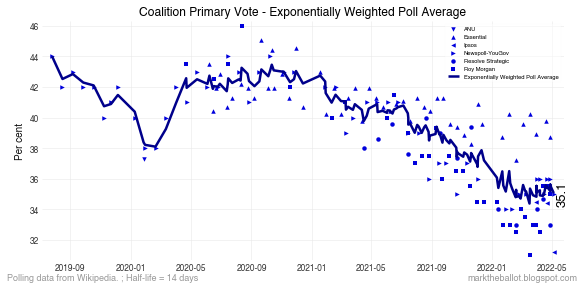

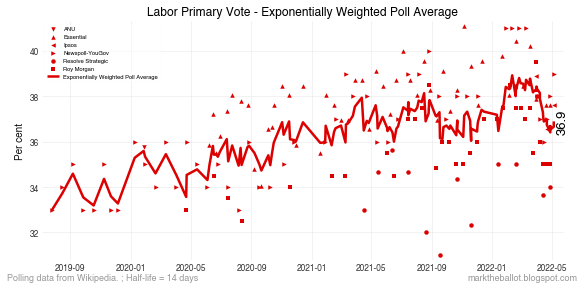

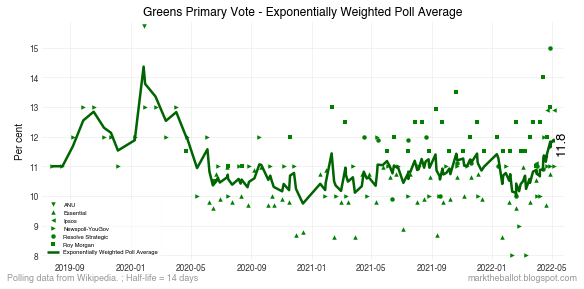

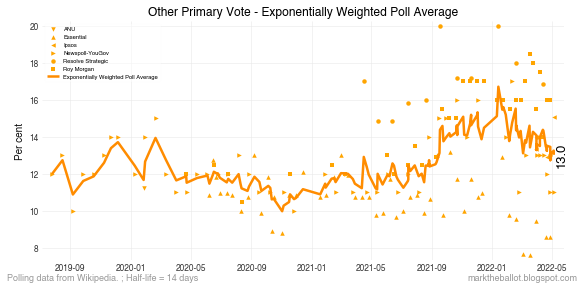

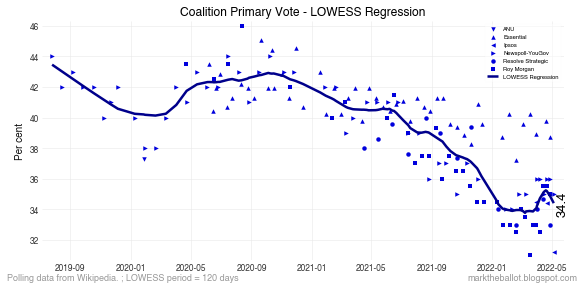

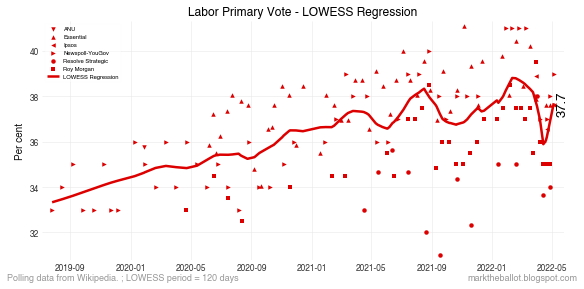

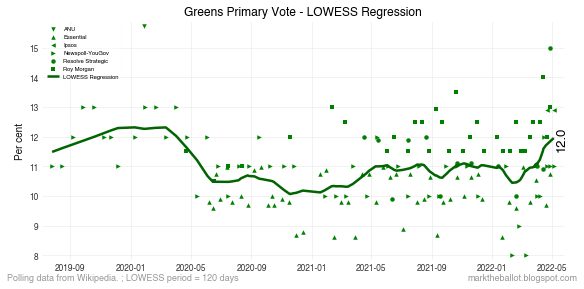

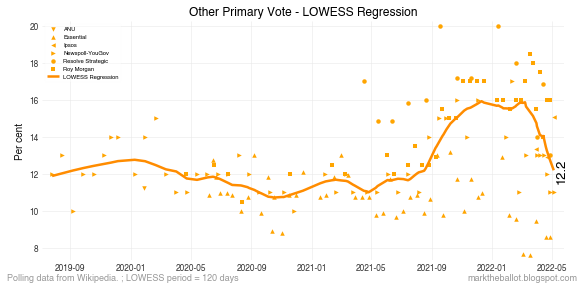

In [26]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(PARTIES, COLUMNS, P_COLORS, L_COLORS):
        title = f'{party} Primary Vote - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)


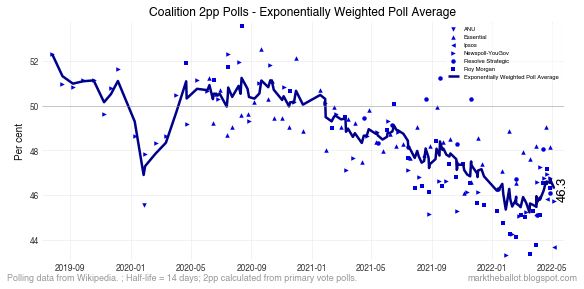

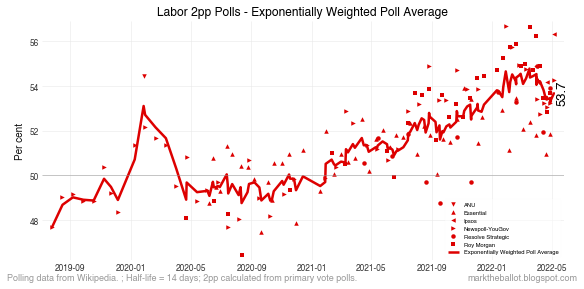

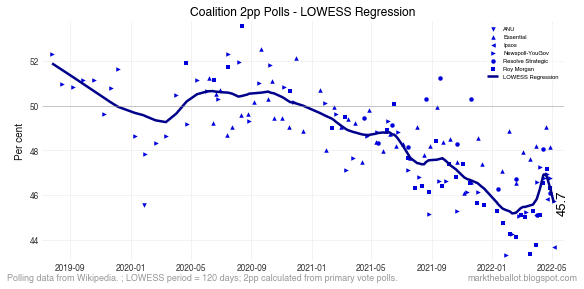

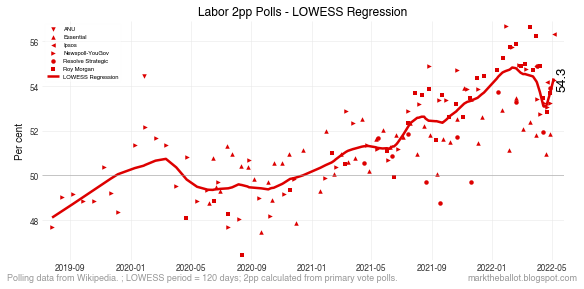

In [27]:
# 2pp, as calculated by me ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')
llfooter = '; 2pp calculated from primary vote polls.'

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Polls - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter+llfooter)

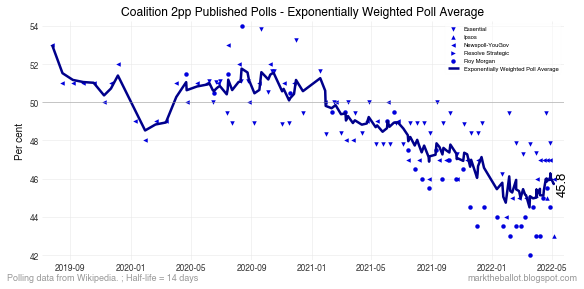

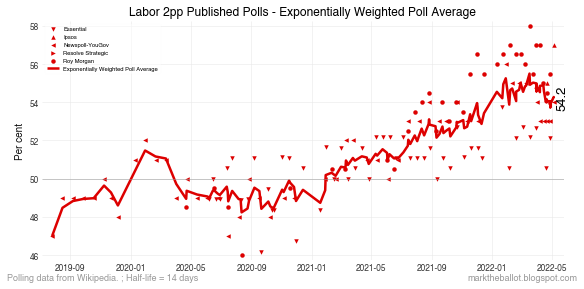

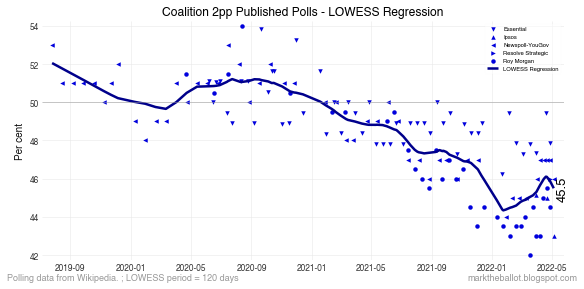

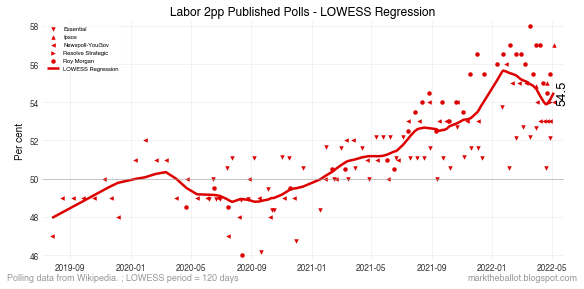

In [28]:
# 2pp, as published by pollsters ...
TPP_COLUMNS = ('2pp vote L/NP', '2pp vote ALP')

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Published Polls - {stem}'
        common.plot_summary_line(df=tpp, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)

### Preferred Prime Minister

In [29]:
ppm.columns

Index(['Mean Date', 'Date', 'Brand', 'Firm', 'Interview mode', 'Sample size',
       'Preferred Prime Minister Morrison',
       'Preferred Prime Minister Albanese',
       'Preferred Prime Minister Don't Know', 'Morrison Satisfied',
       'Morrison Dissatisfied', 'Morrison Don't Know', 'Albanese Satisfied',
       'Albanese Dissatisfied', 'Albanese Don't Know'],
      dtype='object')

In [30]:
def ppm_charts(df, columns, title):

    ax = None
    no_label = False
    fig, ax = common.initiate_plot()
    for col, (name, p_color, l_color) in columns.items():
        common.add_data_points_by_pollster(ax, df, col, p_color, no_label=no_label)
        no_label = True # avoid repeated labels
        lowess = common.calculate_lowess(ppm[col], ppm['Mean Date'], period=150)
        ax.plot(lowess.index, lowess, c=l_color, lw=2.5, label=name)
    common.add_h_refence(ax, reference=50)
    ax.legend(loc='best', ncol=2)
    common.plot_finalise(ax, ylabel='Per cent', title=title, lfooter=LFOOTER)

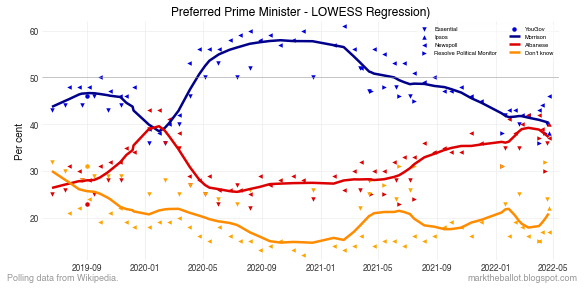

In [31]:
columns = {
    ('Preferred Prime Minister Morrison'): ['Morrison', P_COLOR_COALITION, COLOR_COALITION],    
    ('Preferred Prime Minister Albanese'): ['Albanese', P_COLOR_LABOR, COLOR_LABOR],    
    ("Preferred Prime Minister Don't Know"): ["Don't know", P_COLOR_OTHER, COLOR_OTHER],    
}

title = f'Preferred Prime Minister - LOWESS Regression)'
ppm_charts(ppm, columns, title)

### Satisfaction charts

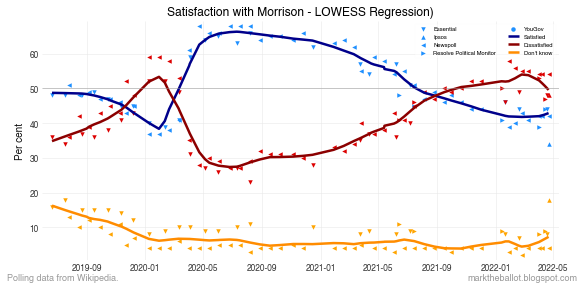

In [32]:
columns = {
    ('Morrison Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Morrison Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Morrison Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Morrison - LOWESS Regression)'
ppm_charts(ppm, columns, title)

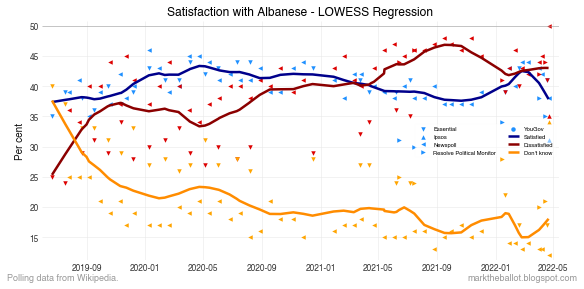

In [33]:
columns = {
    ('Albanese Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Albanese Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Albanese Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Albanese - LOWESS Regression'
ppm_charts(ppm, columns, title)

## Check for under-dispersion with poll results

### Check all - using a simple arithmetic mean

In [42]:
def tpp_recent_dispersion_check(data, column, period_days=None, last_n_polls=None):
    DATE_COL = 'Mean Date'
    SAMPLE_SIZE_COL = 'Sample size'
    PERCENT = 95
    
    # sanity checks
    assert period_days is None or last_n_polls is None
    assert not (period_days is None and last_n_polls is None)
    assert not (period_days is not None and last_n_polls is not None)
    
    # trim data to recent period
    if period_days: 
        cut_off = data[DATE_COL].max() - pd.Timedelta(days=period_days)
        data = data[data[DATE_COL] >= cut_off]
        suffix = f'polls from {cut_off.strftime("%d-%m-%Y")}'
    if last_n_polls:
        data = data.sort_values(by=DATE_COL, ascending=True)
        data = data[-last_n_polls:]
        suffix = f'last {last_n_polls} polls'

    # calculate chi-squared
    X, X_min, X_max, dof, percent = common.calc_chi_squared(data[column], 
                                        sample_sizes=data[SAMPLE_SIZE_COL], 
                                        percent=PERCENT, )
    
    # plot
    fig, ax = common.plot_chi_square(X, X_min, X_max, dof, percent=percent)
    title = (
        f'$\chi^2$ Statistic for recent polls ({column}): DOF={str(dof)} '
        f'({suffix})'
    )
    common.plot_finalise(ax, title=title, xlabel='$\chi^2$', ylabel='Probability',
                         lfooter=LFOOTER + 
                          f'Polls between {data["Mean Date"].min().strftime("%d-%m-%Y")} '
                          f'and {data["Mean Date"].max().strftime("%d-%m-%Y")} '
                          '(mean collection dates). ',
                         save_suffix=str(percent)
                        )

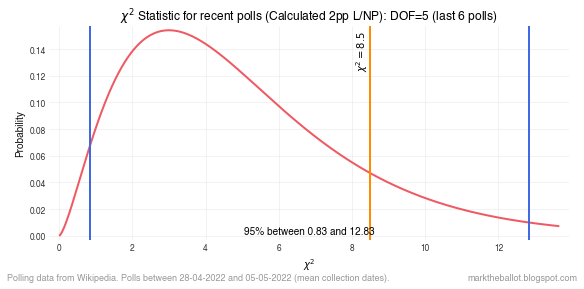

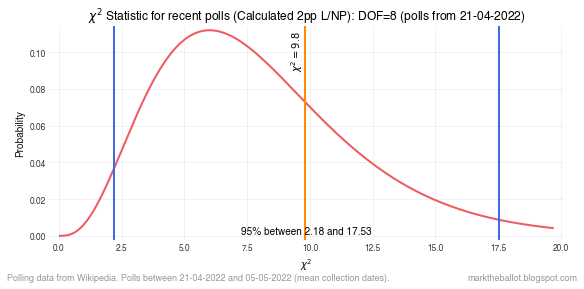

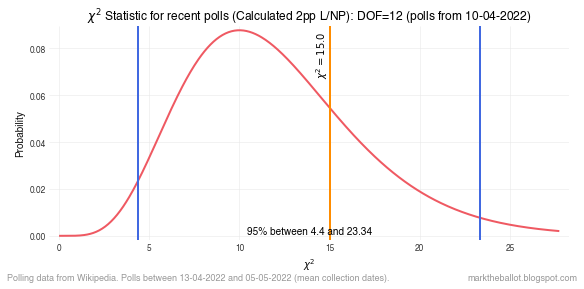

In [44]:
# let's get our 2pp series
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', last_n_polls=6)
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', period_days=14)
period = (pv['Mean Date'].max() - pd.Timestamp('2022-04-10')) / pd.Timedelta(days=1)
tpp_recent_dispersion_check(pv, 'Calculated 2pp L/NP', period_days=period)

### Check all pollsters but Essential - against a moving average

Noting that the Essential numbers are quite different to the other pollster numbers

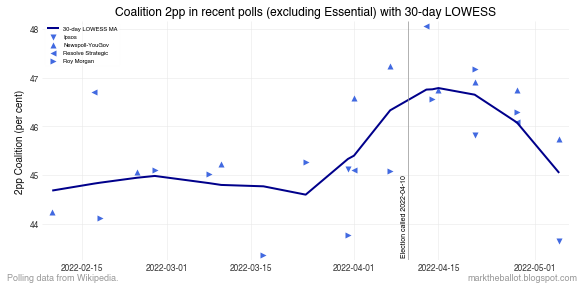

In [36]:
# set-up
EXCLUDE = 'Essential'
SPAN = 12 # weeks
SPAN_DAYS = SPAN * 7
E_CALL_DATE = '2022-04-10'
ELECTION_CALL = pd.Timestamp(E_CALL_DATE)
finish = pv['Mean Date'].max()
start = finish - pd.Timedelta(days=SPAN_DAYS)
LOWESS_PERIOD = 30 # DAYS
assert(LOWESS_PERIOD <= SPAN_DAYS)
MARKERS = ['v', '^', '<', '>', 's', 'o', 'p', 'D', 'd', ]

# data calculations
selection = pv[(pv['Mean Date'] >= start) & (pv['Brand'] != EXCLUDE)].copy()
selection['lowess 2pp'] = common.calculate_lowess(
    series=selection['Calculated 2pp L/NP'],
    times=selection['Mean Date'], 
    period=LOWESS_PERIOD).values

# plot 
fig, ax = common.initiate_plot()
ax.plot(selection['Mean Date'], selection['lowess 2pp'], lw=2, 
        c='darkblue', label=f'{LOWESS_PERIOD}-day LOWESS MA')
for i, brand in enumerate(sorted(selection['Brand'].unique())):
    data = selection[selection['Brand'] == brand]
    ax.scatter(data['Mean Date'], data['Calculated 2pp L/NP'],
               label=brand, marker=MARKERS[i], c='royalblue')
ax.axvline(ELECTION_CALL, lw=0.75, c='#999999')
ax.text(ELECTION_CALL, selection['Calculated 2pp L/NP'].min(),
        f'Election called {E_CALL_DATE}', rotation=90,
        size='x-small', ha='right')

# finalise
ax.legend(loc='upper left')
title = f'Coalition 2pp in recent polls (excluding {EXCLUDE}) with {LOWESS_PERIOD}-day LOWESS'
common.plot_finalise(ax, title=title, xlabel=None, ylabel='2pp Coalition (per cent)',
                     lfooter=LFOOTER,
                     save_suffix=str(LOWESS_PERIOD), )

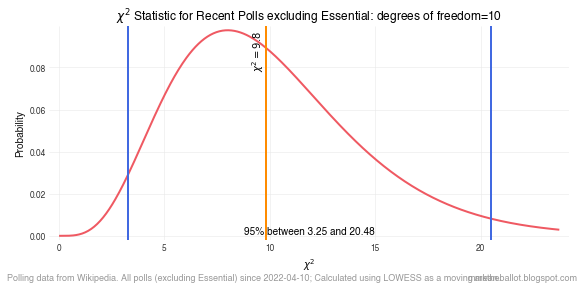

In [37]:
PERCENT = 95
# Chi-squared using LOWESS as the moving mean
chi2 = selection[selection['Mean Date'] >= ELECTION_CALL].copy()
X, X_min, X_max, dof, percent = common.calc_chi_squared(chi2['Calculated 2pp L/NP'], 
                                        sample_sizes=chi2['Sample size'], 
                                        percent=PERCENT, )

# plot
fig, ax = common.plot_chi_square(X, X_min, X_max, dof, percent=percent)
title = (
    f'$\chi^2$ Statistic for Recent Polls excluding {EXCLUDE}: '
    f'degrees of freedom={str(dof)} '
)
common.plot_finalise(ax, title=title, xlabel='$\chi^2$', ylabel='Probability',
                     lfooter=LFOOTER + 
                     f'All polls (excluding {EXCLUDE}) since {E_CALL_DATE}; '
                     'Calculated using LOWESS as a moving mean.',
                     save_suffix=str(percent),
                        )

## Save files

In [38]:
# and save to file
tpp.to_csv(f'{DATA_DIR}two_party_preferred.csv')
pv.to_csv(f'{DATA_DIR}primary_vote.csv')
ppm.to_csv(f'{DATA_DIR}preferred_prime_minister.csv')

## Check for any problems with data capture and cleaning

In [39]:
# Note you should go back and check any warnings that appear here ...
common.print_warnings()

  1: check_row_sums() found issues with 2pp vote
  2: check_row_sums() found issues with Primary vote
  3: check_row_sums() found issues with Preferred Prime Minister
  4: check_row_sums() found issues with Albanese
  5: final_sanity_check() found an issue with "2pp vote L/NP"
  6: final_sanity_check() found an issue with "2pp vote ALP"
  7: final_sanity_check() found an issue with "Primary vote L/NP"
  8: final_sanity_check() found an issue with "Primary vote OTH"
  9: There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]
